In [1]:
from sklearn.svm import SVC
# from sklearn.decomposition import RandomizedPCA
# from sklearn.pipeline import make_pipeline
# from sklearn.cross_validation import train_test_split
# from sklearn.grid_search import GridSearchCV

# scikit-learn 0.19 example
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import fetch_lfw_people


import imageio
import glob
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import logging
# import plotly

# import sklearn
# sklearn.__version__ # = 0.19.2

# display progress logs on stdout
logging.basicConfig(level=logging.INFO, format ='%(asctime)s %(message)s')

/home/gravishlab/.virtualenvs/ants/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/gravishlab/.virtualenvs/ants/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [9]:
%qtconsole

In [3]:
im_locations = '/media/gravishlab/SeagateExpansionDrive/AntTrack/LEAP_training/LvsR_trainingset'
file_list = []
file_list = glob.glob(os.path.join(im_locations, '**/**.png'))
file_list = sorted(file_list)
print(len(file_list))

1285


In [4]:
# prepare dataset
images = np.empty((0,200,200), int)
labels = []#np.chararray((0,1))
for im_path in file_list:
    image = imageio.imread(im_path)
    label = im_path.split('/')[-2]
    images = np.append(images, image[np.newaxis,:,:], axis = 0)
#     print(images.shape, image[np.newaxis,:,:].shape)
#     np.append(labels, [label], axis = 0)
    labels.append(label)
labels = np.array(labels) 

n_samples = images.shape[0]
h = 200
w = 200

X = np.reshape(images, [n_samples, w*h])
n_features = X.shape[1]
target_names = np.array(list(set(labels))).astype('<U17')
y = np.squeeze(np.array([np.where(np.isin(target_names,item))[0] for item in labels]))
n_classes = target_names.shape[0]


print('done')





done


In [35]:
# from example to check right dimensions etc.
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1] # = h*w
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [14]:
# split into a training and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [21]:
# compute eigenimages: unsupervised feature extraction
n_components = 50
print('Extracting the top %d eigenimages from %d images' % (n_components, x_train.shape[0]))
t0 = time()
pca = PCA(n_components = n_components, svd_solver = 'randomized', whiten = True).fit(x_train)
print('done in %0.3fs\n' % (time()-t0))

eigenimages = pca.components_.reshape((n_components, h, w))

print('Projecting the input dat on the eigenimage orthonormal basis')
t0 = time()
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print('done in %0.3fs' % (time()-t0))

Extracting the top 50 eigenimages from 963 images
done in 2.485s

Projecting the input dat on the eigenimage orthonormal basis
done in 0.264s


In [22]:
# Train SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
             'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel ='rbf', class_weight = 'balanced'), param_grid)
clf = clf.fit(x_train_pca, y_train)
print('done in %0.3fs' % (time()-t0))
print('best estimator found by grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 2.061s
best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [23]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(x_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
# print(classification_report(y_test, y_pred, target_names=target_labels))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.013s
             precision    recall  f1-score   support

      Blank       0.80      1.00      0.89         4
      Right       1.00      0.99      1.00       165
       Left       1.00      1.00      1.00       153

avg / total       1.00      1.00      1.00       322

[[  4   0   0]
 [  1 164   0]
 [  0   0 153]]


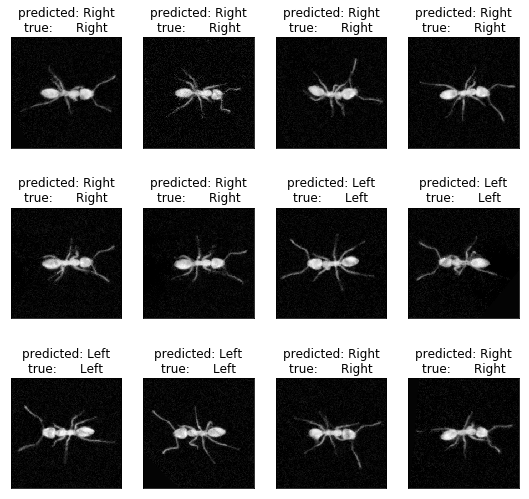

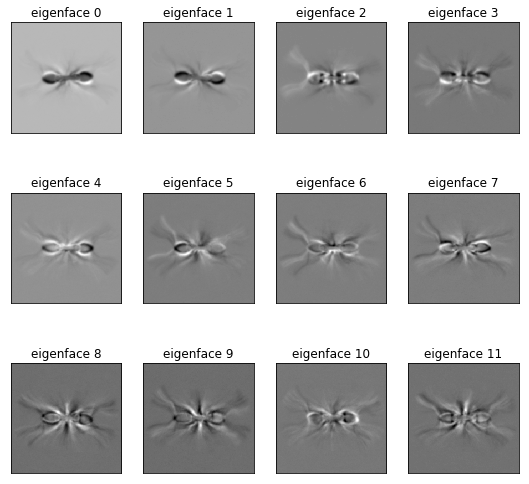

In [24]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(x_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
eigenimage_titles = ["eigenface %d" % i for i in range(eigenimages.shape[0])]
plot_gallery(eigenimages, eigenimage_titles, h, w)

plt.show()

In [7]:
# Save data to use for future
import h5py
hf = h5py.File("%s/SVMdata.h5"%(im_locations),'w')
hf.create_dataset('X', data=X)
hf.create_dataset('y', data=y)
# hf.create_dataset('target_names', data=[name[0] for name in target_names])
hf.create_dataset('labels', data=labels.astype("S10"))
hf.create_dataset('target_names', data=target_names.astype("S10"))

hf.close()

/home/gravishlab/.virtualenvs/ants/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['Right']
done in 0.012s
conf [[-0.32080592  2.5         0.82080592]]


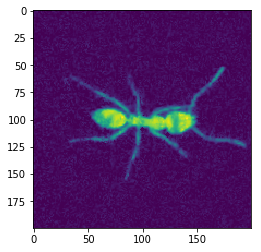

In [20]:
# Test one image

t0 = time()
im_test_pca = pca.transform( np.reshape(image, [1, w*h]))
im_pred = clf.predict(im_test_pca)
print(target_names[im_pred])
plt.imshow(image)
print("done in %0.3fs" % (time() - t0))
print('conf', clf.decision_function(im_test_pca))

Running PCA and making SVM model
--- best estimator found by grid search:
--- SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
['Right']


NameError: name 'glennadkd6y' is not defined

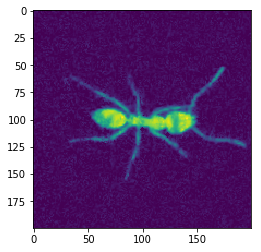

In [92]:
def run_SVM_for_LvR():
    SVM_path = '/media/gravishlab/SeagateExpansionDrive/AntTrack/LEAP_training/LvsR_trainingset/SVMdata.h5'
    from sklearn.grid_search import GridSearchCV
    from sklearn.cross_validation import train_test_split
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.decomposition import PCA
    from sklearn.svm import SVC

    if os.path.exists(SVM_path):
#                 print('ant%i predictions exist'%ant_num)
        hf = h5py.File(SVM_path,'r')
        X = hf['X'][()].astype(np.float32) #hf.get('positions_pred')
        y = hf['y'][()] #hf.get('conf_pred')
        target_names = hf['target_names'][()]
        target_names = target_names.astype('<U5')
        n_samples = X.shape[0]
        n_classes = target_names.shape[0]
        h = 200
        w = 200
        n_features = X.shape[1]
        
        # compute eigenimages (unsupervised feature extraction)
        n_components = 15
        pca = PCA(n_components = n_components, svd_solver = 'randomized', whiten = True).fit(X)
        # Projecting the input dat on the eigenimage orthonormal basis 
        x_pca = pca.transform(X)
        # Train SVM classification model
        param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
             'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
        clf = GridSearchCV(SVC(kernel ='rbf', class_weight = 'balanced'), param_grid)
        clf = clf.fit(x_pca, y)
        print('--- best estimator found by grid search:')
        print('---', clf.best_estimator_)
    else:
        print('--- No data for SVM')
    
    return pca, clf, target_names



print('Running PCA and making SVM model')
pca, clf, target_names = run_SVM_for_LvR()

im_pca = pca.transform( np.reshape(image, [1, 200*200]))
im_pred = clf.predict(im_pca)
print(target_names[im_pred])
plt.imshow(image)
glennadkd6y

In [27]:
# get pca
n_components = 10
pca = RandomizedPCA(n_components = n_components, whiten = True)


svc = SVC(kernel = 'rbf', class_weight='balanced') #,param_grid)
model = make_pipeline(pca, svc)



/home/gravishlab/.virtualenvs/ants/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [32]:
# train model?
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, random_state = 42)
param_grid = {'svc__C': [1, 5, 10, 50],
             'svc__gamma': [0.0001, 0.0005, 0.001, 0.005], }
grid = GridSearchCV(model, param_grid)

%time grid.fit(xtrain, ytrain)
# print(grid.best_params_)

/home/gravishlab/.virtualenvs/ants/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/home/gravishlab/.virtualenvs/ants/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


ValueError: Found array with dim 3. Estimator expected <= 2.